In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import math

In [2]:
#All data together

folder = Path(
    "C:/Users/tobia/OneDrive/Skrivebord/UNI/4. semester/Dataprojekt/2023 AAR vaskeri data"
)
files = list(folder.glob("PLC*.xlsx"))            # matches PLC, Product....xlsx etc.

dfs = []
monthly_data = {}

for f in files:
    df = pd.read_excel(f, header=2)                         # optionally: sheet_name="Sheet1"
    df["source_file"] = f.name                    # helpful traceability
    dfs.append(df)

    #dataframe for each individual month
    month_name = f.stem
    monthly_data[month_name] = df

all_data = pd.concat(dfs, ignore_index=True)
print(all_data.shape)
print(all_data.columns)
print(monthly_data.keys())

(248711, 7)
Index(['Produkt - Produkt', 'Kassationsårsag (ui)',
       'Stk. tøj per kassationsdato', 'Dage i cirkulation', 'Total antal vask',
       'Unik Kode (ui)', 'source_file'],
      dtype='object')
dict_keys(['PLC, Product detaljeret, Aarhus, Apr. 2023', 'PLC, Product detaljeret, Aarhus, Aug. 2023', 'PLC, Product detaljeret, Aarhus, Dec. 2023', 'PLC, Product detaljeret, Aarhus, Feb. 2023', 'PLC, Product detaljeret, Aarhus, Jan. 2023', 'PLC, Product detaljeret, Aarhus, Jul. 2023', 'PLC, Product detaljeret, Aarhus, Jun. 2023', 'PLC, Product detaljeret, Aarhus, Maj, 2023', 'PLC, Product detaljeret, Aarhus, Mar. 2023', 'PLC, Product detaljeret, Aarhus, Nov. 2023', 'PLC, Product detaljeret, Aarhus, Okt. 2023', 'PLC, Product detaljeret, Aarhus, Sep. 2023'])


# Unique ui codes check

## Unique in whole dataset

In [3]:
n_unique_prod_year = (
    all_data
    .dropna(subset=["Unik Kode (ui)"])
    .groupby("Unik Kode (ui)")["Produkt - Produkt"] #group by ui and look at product for each group
    .nunique() #counting how many products each ui maps to
)
bad_ui_year = n_unique_prod_year[n_unique_prod_year > 1].index #filter for only conflicting ui's

conflicts_year = (
            all_data[all_data["Unik Kode (ui)"].isin(bad_ui_year)] #selecting rows which ui's are non-unique
            .loc[:, ["Unik Kode (ui)", "Produkt - Produkt", "source_file"]] # selecting only the stated rows
            .drop_duplicates() #dropping duplicates of bad ui's (same prod, same ui, same file)
            .sort_values(["Unik Kode (ui)", "Produkt - Produkt"]) #sorting for readability
        )

print("Number of conflicting UI codes in full dataset:", len(bad_ui_year))
conflicts_year.head(10)

Number of conflicting UI codes in full dataset: 439


,Unik Kode (ui),Produkt - Produkt,source_file
83199,00D007440139,09182 Overall Kblå Hygiejne,"PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
100711,00D007440139,23361 Overall Food Kblå,"PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
26700,00D0075C79CB,06325 Kokkebuss. Brod. Grå P/B,"PLC, Product detaljeret, Aarhus, Aug. 2023.xlsx"
228354,00D0075C79CB,06325 Kokkebuss. Brod. Grå P/B,"PLC, Product detaljeret, Aarhus, Okt. 2023.xlsx"
39935,00D0075C79CB,30206 Jakke Løvbjerg sort,"PLC, Product detaljeret, Aarhus, Aug. 2023.xlsx"
55818,00D0085C7770,01806 Jakke Termo Marineblå,"PLC, Product detaljeret, Aarhus, Feb. 2023.xlsx"
79324,00D0085C7770,23897 Termojakke u/lom mblå,"PLC, Product detaljeret, Aarhus, Feb. 2023.xlsx"
89563,00D0085D8F1F,09182 Overall Kblå Hygiejne,"PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
100712,00D0085D8F1F,23361 Overall Food Kblå,"PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
75071,00D00960C27E,10129 Overall FlmQ so/grå brystlom,"PLC, Product detaljeret, Aarhus, Feb. 2023.xlsx"


Codes are not unique, so for grouping additional arguments are needed.

## Unique within months?

checking which months are problematic

In [4]:
#Unique ui check
conflicts_by_month = {}

for month, df in monthly_data.items():
    #counting distinct products per ui code
    n_unique_prod = (
        df.dropna(subset=["Unik Kode (ui)"]) #ignore rows with no ui
        .groupby("Unik Kode (ui)")["Produkt - Produkt"] #group by ui and look at product for each group
        .nunique() #counting how many products each ui maps to
    )
    
    bad_ui = n_unique_prod[n_unique_prod > 1].index #indexes of uis with more than one product attached

    if len(bad_ui) > 0: #ui not unique
        conflicts = (
            df[df["Unik Kode (ui)"].isin(bad_ui)] #selecting rows which ui's are non-unique
            .loc[:, ["Unik Kode (ui)", "Produkt - Produkt", "source_file"]] # selecting only the stated rows
            .drop_duplicates() #dropping duplicates of bad ui's (same prod, same ui, same file)
            .sort_values(["Unik Kode (ui)", "Produkt - Produkt"]) #sorting for readability
        )
        conflicts_by_month[month] = conflicts #store a df of each months bad ui's
        print(f"{month}: ui codes map to multiple products")

    else: #all ui's unique
        print(f"{month}: All ui codes map a single product.")

conflicts_by_month["PLC, Product detaljeret, Aarhus, Apr. 2023"].head(10) #printing example of conflicting rows

PLC, Product detaljeret, Aarhus, Apr. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Aug. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Dec. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Feb. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Jan. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Jul. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Jun. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Maj, 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Mar. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Nov. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Okt. 2023: ui codes map to multiple products
PLC, Product detaljeret, Aarhus, Sep. 2023: ui codes map to multiple products


,Unik Kode (ui),Produkt - Produkt,source_file
16650,30155C97D461A4C00033AE2E,12652 T-shirt l/æ flame/antis navy,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17571,30155C97D461A4C00033AE2E,25991 Jakke FlamePro NY mar/rød,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
16651,30155C97D461A4C00033AED0,12652 T-shirt l/æ flame/antis navy,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17572,30155C97D461A4C00033AED0,25991 Jakke FlamePro NY mar/rød,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
16912,30155C97D461A4C00066A70B,02811 Benklæde En471 Orange/Mblå,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17588,30155C97D461A4C00066A70B,26619 Arbejdsjakke ACC azur/marine,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17300,30155C97D461A4C000BE7AE2,22411 Benkl Revisi EN20471 kl2 gul,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17470,30155C97D461A4C000BE7AE2,24786 Skjorte Uni Navy Sporty,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17181,30155C97D461A4C000C691F7,12464 Vest dame med knap navy P/B,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"
17319,30155C97D461A4C000C691F7,23861 Cardigan uni sweat m/lyn navy,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx"


Codes are not unique within months for all months.

## ui uniques within clothing categories

In [ ]:
#List of all unique products
products = all_data["Produkt - Produkt"].dropna().unique()
print(products)

['06360 Bagerskjorte HV. L/Æ P/B' '03655 Skjorte Bager HV.K/Æ P/B CC'
 '04290 Skjorte Marine P/B' ... '22784 Termokedeldragt Tombos ora'
 '26328 T-shirt l/æ kl.3 orange' '27415 Termovest Moncton Sort']


I first check the subset of T-Shirts

In [ ]:
#Filtering for only T-shirts
tshirts = all_data[all_data["Produkt - Produkt"].str.contains(r"\bT-shirt\b", case=False, na=False)]
print(f"n_tshirts: {len(tshirts)}")

#same method as above
tshirt_conflicts = (
    tshirts
    .groupby("Unik Kode (ui)")["Produkt - Produkt"]
    .nunique()
)

bad_tshirt_ui = tshirt_conflicts[tshirt_conflicts > 1].index


conflicts_tshirt = (
            tshirts[tshirts["Unik Kode (ui)"].isin(bad_tshirt_ui)] #selecting rows which ui's are non-unique
            .loc[:, ["Unik Kode (ui)", "Produkt - Produkt", "source_file"]] # selecting only the stated rows
            .drop_duplicates() #dropping duplicates of bad ui's (same prod, same ui, same file)
            .sort_values(["Unik Kode (ui)", "Produkt - Produkt"]) #sorting for readability
        )

print("Conflicting T-shirt UIs:", len(bad_tshirt_ui))
conflicts_tshirt.head(10)

n_tshirts: 73556
Conflicting T-shirt UIs: 92


,Unik Kode (ui),Produkt - Produkt,source_file
53818,30155C97D461A4C000C0934D,01083 T-Shirt unisex hvid k/æ P/B,"PLC, Product detaljeret, Aarhus, Dec. 2023.xlsx"
39339,30155C97D461A4C000C0934D,01089 T-Shirt Sand Bomuld,"PLC, Product detaljeret, Aarhus, Aug. 2023.xlsx"
145658,30155C97D461A4C000C097D2,01085 T-Shirt Gråmelange p/b,"PLC, Product detaljeret, Aarhus, Jun. 2023.xlsx"
53485,30155C97D461A4C000C097D2,05468 T-Shirt Grafit Melange P/B,"PLC, Product detaljeret, Aarhus, Dec. 2023.xlsx"
117494,30155C97D461A4C000C0AF69,13084 T-shirt prowear dame navy pb,"PLC, Product detaljeret, Aarhus, Jul. 2023.xlsx"
117504,30155C97D461A4C000C0AF69,13658 T-shirt dame lyseblå Prowear,"PLC, Product detaljeret, Aarhus, Jul. 2023.xlsx"
117495,30155C97D461A4C000C0B001,13084 T-shirt prowear dame navy pb,"PLC, Product detaljeret, Aarhus, Jul. 2023.xlsx"
247125,30155C97D461A4C000C0B001,13658 T-shirt dame lyseblå Prowear,"PLC, Product detaljeret, Aarhus, Sep. 2023.xlsx"
117496,30155C97D461A4C000C0B040,13084 T-shirt prowear dame navy pb,"PLC, Product detaljeret, Aarhus, Jul. 2023.xlsx"
227130,30155C97D461A4C000C0B040,13658 T-shirt dame lyseblå Prowear,"PLC, Product detaljeret, Aarhus, Okt. 2023.xlsx"


T-shirt not unique ui's

Remove these rows when plotting or can is it unecessary? (spørg morten)

In order to plot individual t-shirt i.e. a scatterplot we can then

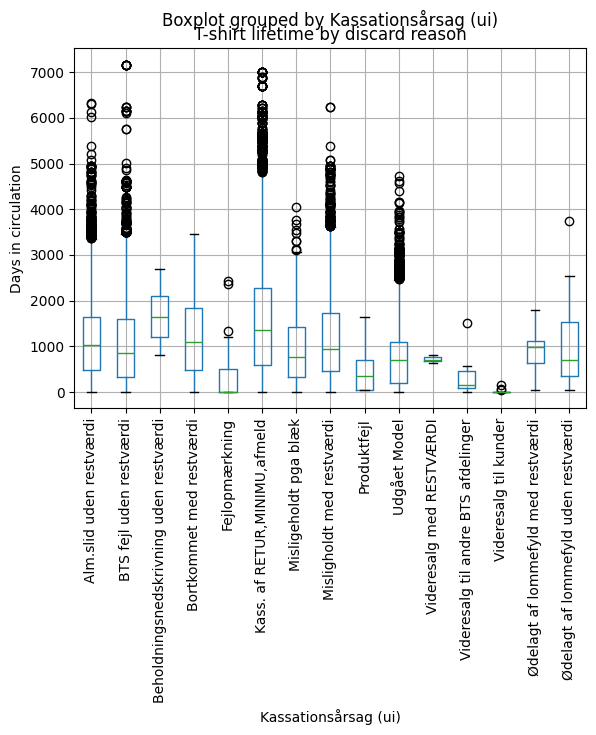

In [ ]:
#non-important plot used as a test
tshirts_stats = (
    tshirts
    .groupby("Unik Kode (ui)")
    .agg({
        "Dage i cirkulation": "max", #choosing the max recorded daycount
        "Kassationsårsag (ui)": "last" #choosing the last record in case of ui duplicates. 
        #Possible value loss in the above "last" statement as it assumed that a ui cant be reused
    })
    .dropna(subset=["Dage i cirkulation"]) 
)
tshirts_stats.boxplot(
    column="Dage i cirkulation",
    by="Kassationsårsag (ui)",
    rot=90
)

plt.ylabel("Days in circulation")
plt.title("T-shirt lifetime by discard reason")
plt.show()

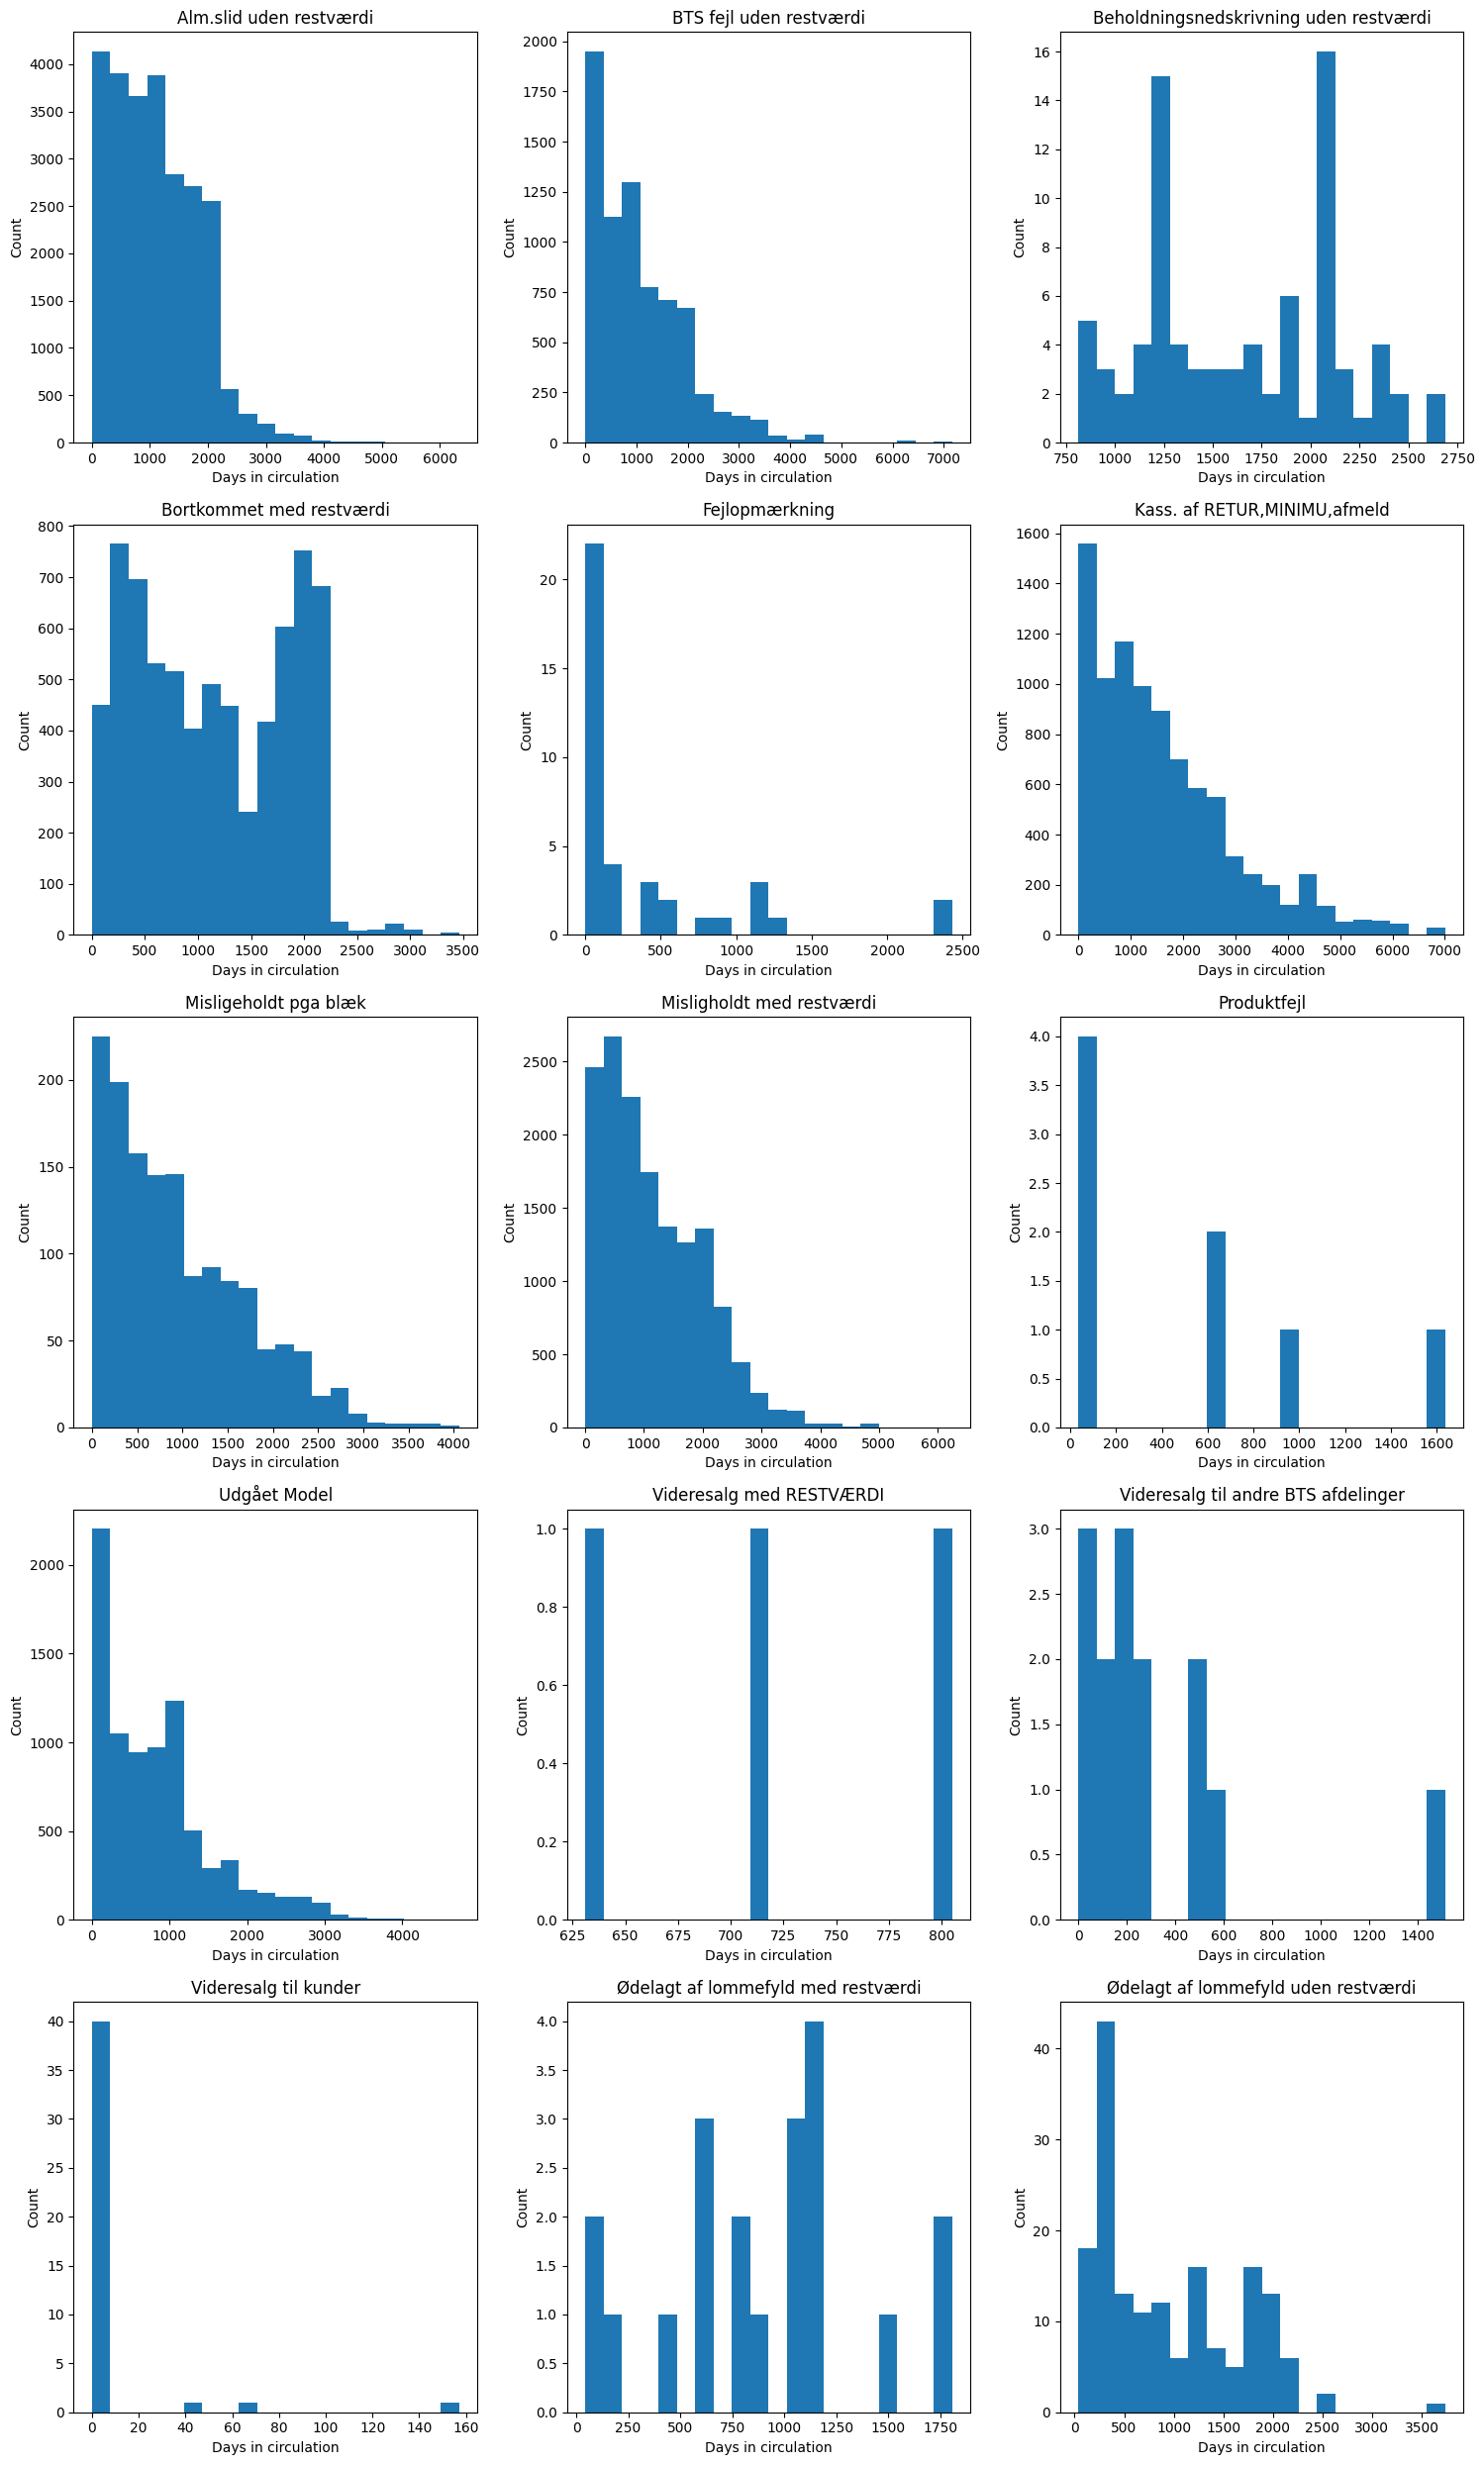

In [20]:
# group data
groups = list(tshirts_stats.groupby("Kassationsårsag (ui)"))

n = len(groups)
cols = 3  # n plots per row
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for ax, (reason, group) in zip(axes, groups):
    ax.hist(group["Dage i cirkulation"], bins=20)
    ax.set_title(reason)
    ax.set_xlabel("Days in circulation")
    ax.set_ylabel("Count")

# Removing empty plots if necessary
for i in range(len(groups), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Svært at kommentere på når n antal t-shirts for kassationsårsag er lille